In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import iqr,skew 
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,cross_val_predict,KFold, StratifiedKFold,GridSearchCV,RandomizedSearchCV
import pickle

import time
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns',15)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

In [11]:
#Importing Data sets
file_path_train= 'C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/data/raw/train_Loan.csv'
file_path_test='C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/data/raw/test_Loan.csv'
loan_train=pd.read_csv(file_path_train)
loan_test=pd.read_csv(file_path_test)

 ## 2. EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
loan_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


There are a total of 614 entries. Several of the variables present null values: Gender (13 nulls), Married(3), Dependents (15), Self_Employed (32), LoanAmount(22), Loan_Amount_Term(14) and Credit_History(50). Out of the toal of 13 variables, 10 are Categorical variables (if we include Credit_History and Loan_Amount_Term as cartegorical) and 3 numerical

### 2.1 UNIVARIATE ANALYSIS
#### 2.1.1 TARGET VARIABLE

We will first take a look at the distribution of the target variable

(Y    422
 N    192
 Name: Loan_Status, dtype: int64,
 Y   0.68730
 N   0.31270
 Name: Loan_Status, dtype: float64,
 <AxesSubplot:>)

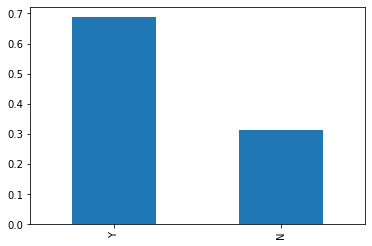

In [5]:
loan_train.Loan_Status.value_counts(), \
loan_train.Loan_Status.value_counts(normalize='True'), \
loan_train.Loan_Status.value_counts(normalize='True').plot(kind='bar')

We see that almost 70% of the loans are approved (422 of 614 applications in the dataset). The data is imbalanced.

#### 1.1.2 CATEGORICAL VARIABLES

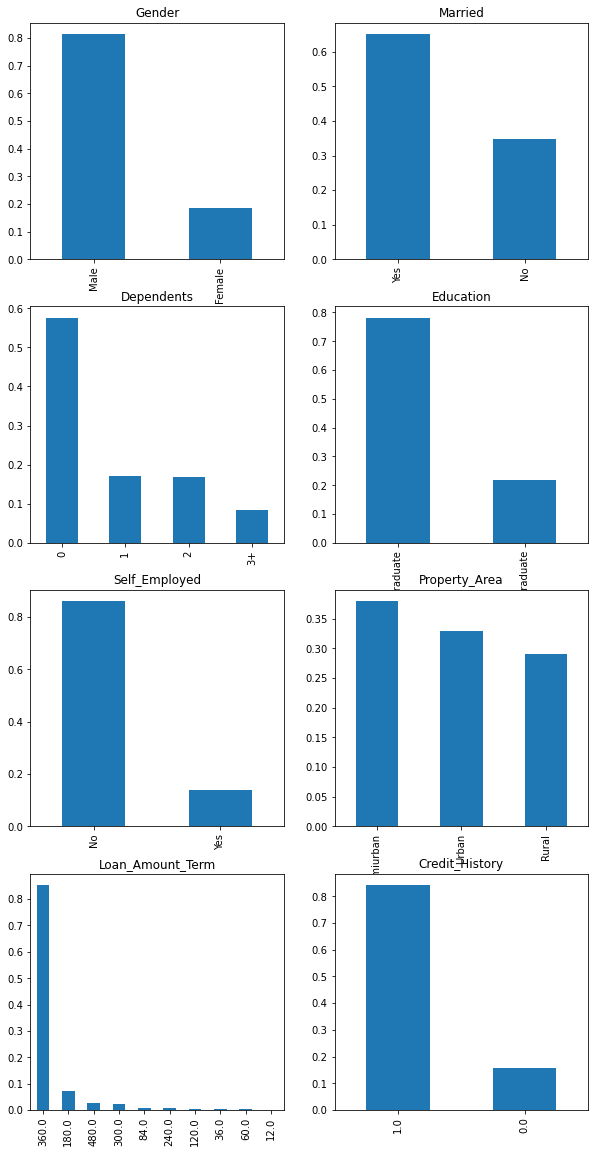

In [6]:
# Creating a boolean mask for categorical columns
categorical_mask = loan_train.dtypes == object
# Get list of categorical column names
cat_columns = loan_train.columns[categorical_mask].tolist()
#Add loan term and credit history as categorical and remove the target variable and the ID category from the list
cat_columns=cat_columns+['Loan_Amount_Term','Credit_History']
for i in ('Loan_ID','Loan_Status'): 
    cat_columns.remove(i)
    
#Plot distribution of categorical variables
for i in range(len(cat_columns)):
    plt.subplot(4,2,i+1)
    loan_train[cat_columns[i]].value_counts(normalize='True').plot(kind='bar',
              figsize=(10,20),title=cat_columns[i])

Majority of males (80%) and of married (65%) applicants. Also a wide predominancy of applicants with 0 dependents. Close to 80% graduates and only around 15% self employed. The distribution by property area is more evenly distributed between Semiurban (38%,), urban (32%) and rural (30%) .Regarding the loan term, the vast majority (85%) are 30 year term loans followed by far from 15 years mortgage (6%). Finally, the proportion of applicants with credit history is predominantly possitive (85 %).

To make sure that the distribution of the variables in the test set is similar to the training set, we generate the same plots with the test dataset.

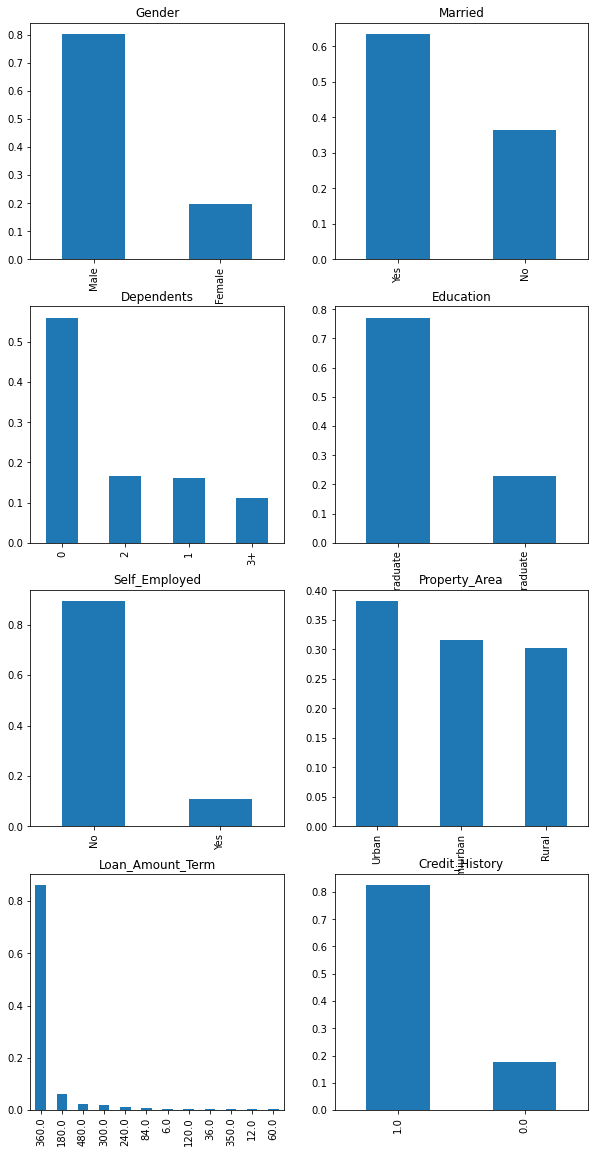

In [12]:
#Plot distribution of categorical variables in the test set
for i in range(len(cat_columns)):
    ax=plt.subplot(4,2,i+1)
    loan_test[cat_columns[i]].value_counts(normalize='True').plot(kind='bar',
              figsize=(10,20),title=cat_columns[i],ax=ax)   


We can appreciate a similar distribution than in the training set.
#### 1.1.3 NUMERICAL VARIABLES

In [14]:
# Create list of numerical column names. Remove Loan Amount Term and Credit History because we treat them as categorical
num_columns= loan_train.columns[~categorical_mask].tolist()
for i in ('Loan_Amount_Term','Credit_History'): 
    num_columns.remove(i)

num_columns

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

##### - Applicant Income

Applicant income mean is $5403
Applicant income median is $3812


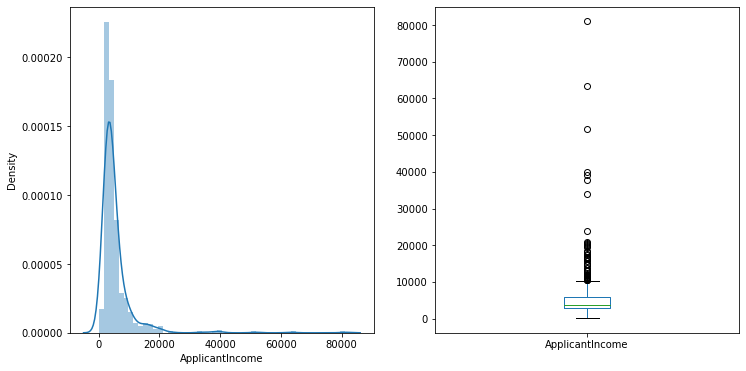

In [15]:
#Applicant Income distribution plot and boxplot
plt.figure(figsize=(12,6))
plt.subplot (1,2,1) 
sns.distplot(loan_train.ApplicantIncome)
plt.subplot (1,2,2) 
loan_train.ApplicantIncome.plot(kind='box')


print("Applicant income mean is $" + "{:.0f}".format(loan_train.ApplicantIncome.mean()))
print("Applicant income median is $" + "{:.0f}".format(loan_train.ApplicantIncome.median()))

We appreciate a clear left skewed distribution, with the mean significantly higher than the median (5403 vs 3812) and several extreme values.
Another way to evaluate the skewness of the income variables is using a probability plot. We plot the applicant income against a theoretical normal distribution. 

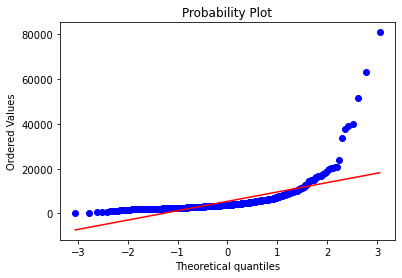

In [16]:
#Ploting a probability plot
res = stats.probplot(loan_train.ApplicantIncome, dist='norm',plot=plt)
plt.show()

##### - Coapplicant Income

Coapplicant income mean is $1621
Coapplicant income median is $1188


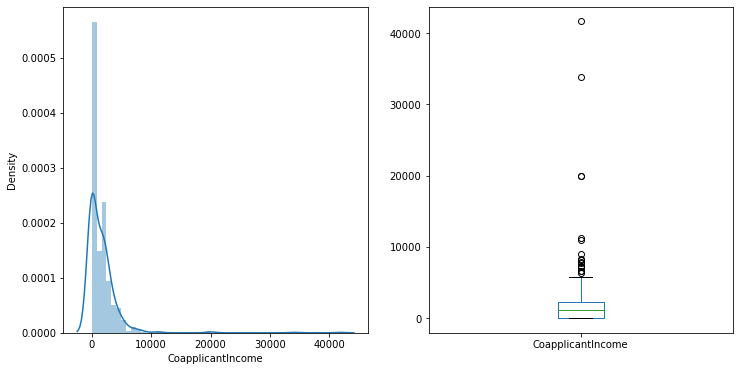

In [17]:
#Coapplicant Income distribution and boxplot
plt.figure(figsize=(12,6))
plt.subplot (1,2,1) 
sns.distplot(loan_train.CoapplicantIncome)
plt.subplot (1,2,2) 
loan_train.CoapplicantIncome.plot(kind='box')

print("Coapplicant income mean is $" + "{:.0f}".format(loan_train.CoapplicantIncome.mean()))
print("Coapplicant income median is $" + "{:.0f}".format(loan_train.CoapplicantIncome.median()))

We appreciate the same behaviour than in the applicant income case, with a left skewed distribution. 

##### - Loan Amount

Loan amount mean is $146
Loan amount median is $128


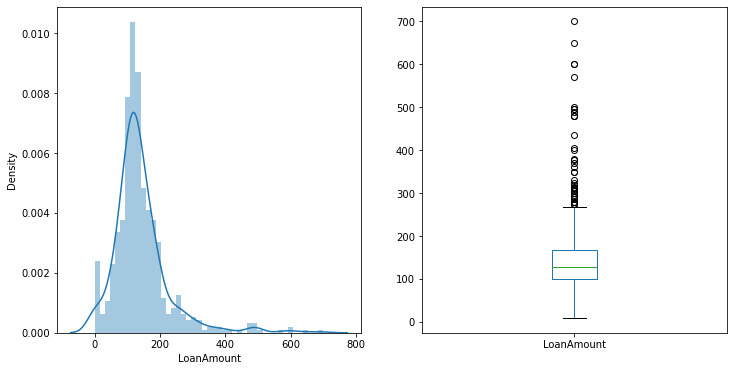

In [18]:
#Loan Amount distribution and boxplot
plt.figure(figsize=(12,6))
plt.subplot (1,2,1) 
sns.distplot(loan_train.LoanAmount.fillna(0))
plt.subplot (1,2,2) 
loan_train.LoanAmount.plot(kind='box')

print("Loan amount mean is $" + "{:.0f}".format(loan_train.LoanAmount.mean()))
print("Loan amount median is $" + "{:.0f}".format(loan_train.LoanAmount.median()))

Loan amount is closer to a normal distribution than the income variables, but still left skewed.

### 2.2 MULTIVARIATE ANALYSIS
#### 2.2.1 AGAINST TARGET VARIABLE
##### 2.2.1.1 CATEGORICAL VARIABLES

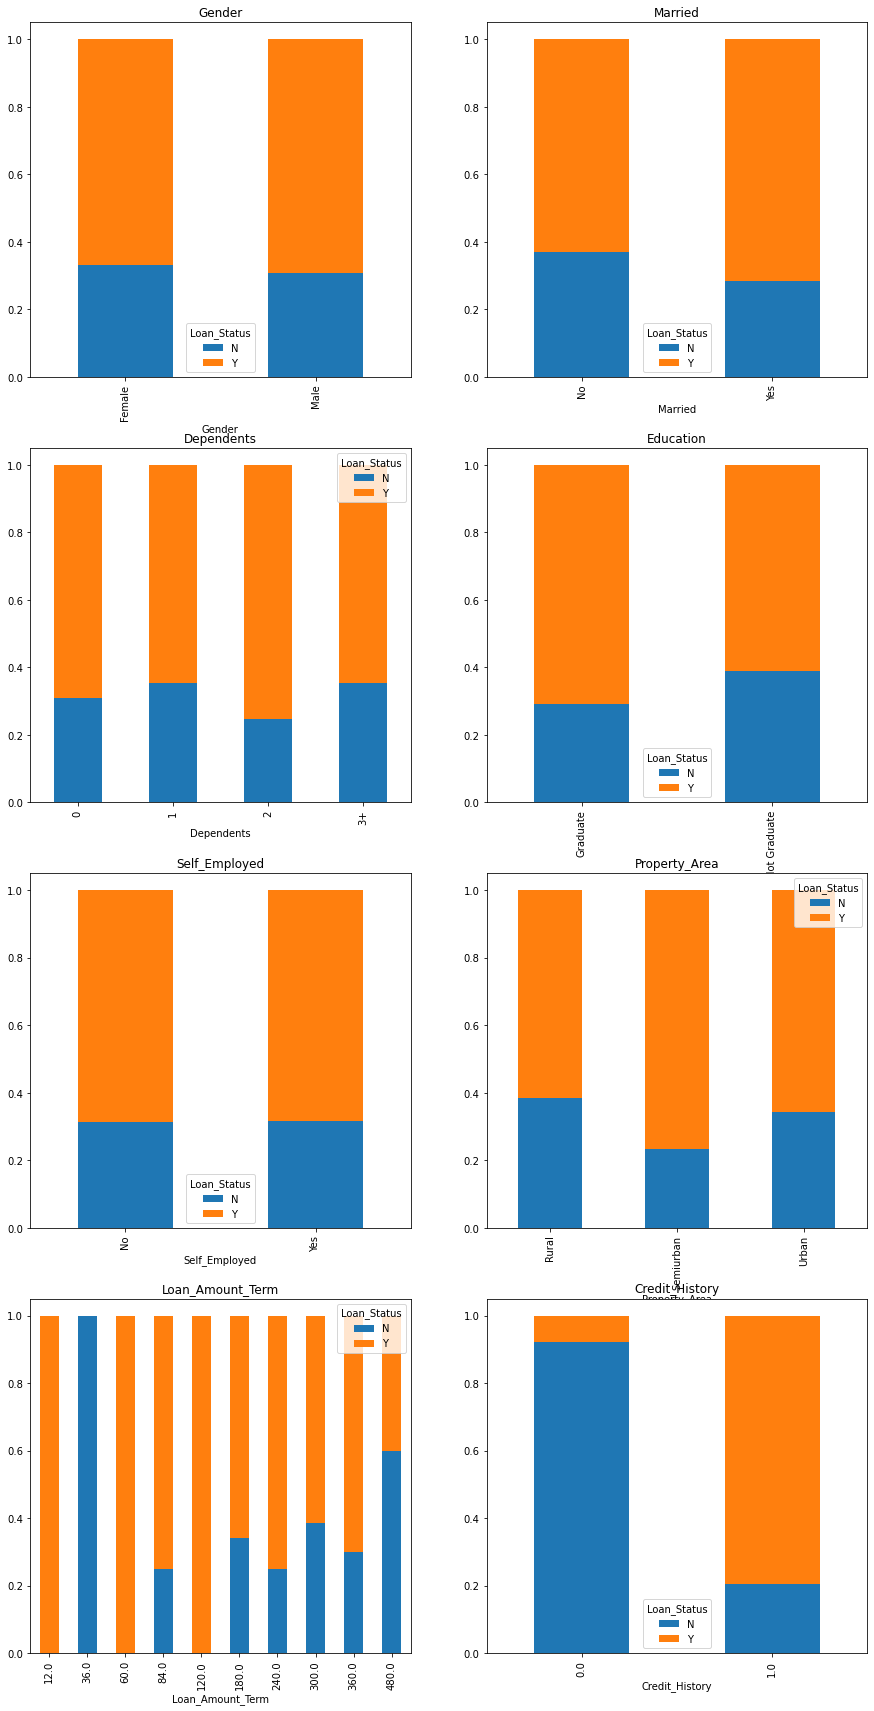

In [19]:
#Creating stacked bar charts of loan status agaisnt each categorical variable 
for i in range(len(cat_columns)):  
    crosstable_norm= pd.crosstab(loan_train[cat_columns[i]],loan_train.Loan_Status,normalize='index')
    ax=plt.subplot(4,2,i+1)
    crosstable_norm.plot(kind='bar',stacked='True',title=cat_columns[i],ax=ax,figsize=(15,30))

We see that the categorical variables that present more relation with Loan Status are Married, Education, Property Area and overwhelmingly, Credit History. The main takeaway is the weight that Credit History has in the approval decission, since more than 90% of applications without Credit History are rejected. 

Some of our initial intuitions are confirmed, such as the graduate applicants having a higher ratio of approval. However, we also see that self-employeed applicants do not to have a lower rate of approval as we expected.

To complement the analysis of the relation between the categorical variables and the target variable we can perform a chi independence test:

In [20]:
chi_values={}
list_chi=[]
for i in range(len(cat_columns)):  
    crosstable= pd.crosstab(loan_train[cat_columns[i]],loan_train.Loan_Status)
    chi,p,dof, ef= stats.chi2_contingency(crosstable)
    chi_values={'cat_1':cat_columns[i],'cat_2':'Loan_Status','chi':chi,'p':p,'dof':dof,'ef':ef}
    list_chi.append(chi_values)
    
df_chi=pd.DataFrame(list_chi)
print(df_chi[['cat_1','cat_2','p']])

              cat_1        cat_2       p
0            Gender  Loan_Status 0.70865
1           Married  Loan_Status 0.03439
2        Dependents  Loan_Status 0.36785
3         Education  Loan_Status 0.04310
4     Self_Employed  Loan_Status 0.94200
5     Property_Area  Loan_Status 0.00214
6  Loan_Amount_Term  Loan_Status 0.12186
7    Credit_History  Loan_Status 0.00000


Taking a p value of 5% as a reference, we confirm the results of the charts as we see that Married, Education, Property Area and above all, Credit History are the strongest related variables to Loan Status.

##### 2.2.1.2 NUMERICAL VARIABLES

<AxesSubplot:xlabel='Loan_Status'>

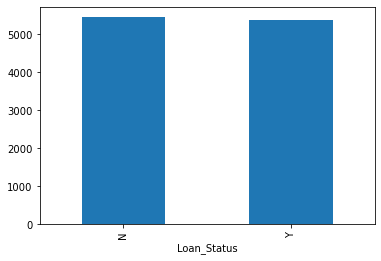

In [21]:
#ApplicantIncome
loan_train.groupby('Loan_Status').ApplicantIncome.mean().plot.bar()

The means of the applicants income for loan approved and not approved are similar. This goes against our intuition because we were expecting to see the approval rate to increase as the income increase. Anyways, using the mean can be misleading so we next will create bins to explore further the relationship.

0-2000         41
2000-2500      67
2500-3000      69
3000-3500      86
3500-4000      71
4000-4500      42
4500-5000      47
5000-6000      54
6000-7000      34
7000-10000     51
10000-81000    52
Name: ApplicantIncome, dtype: int64

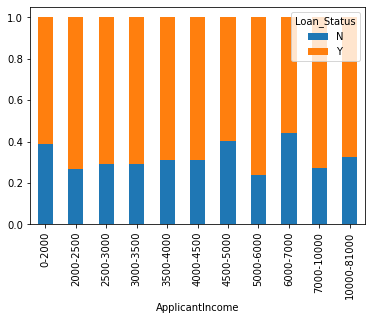

In [22]:
bins=[0,2000,2500,3000,3500,4000,4500,5000,6000,7000,10000,81000]
labels=[f'{i}-{j}' for i,j in zip(bins[:-1],bins[1:])]

'''Note: Neither the estimated standard deviation northe Freedman and Diaconis rule (
(bin width: W = 2 (IQR) N-1/3) worked to define the number of bins. The number of bins were manually adjusted the number of bins 
trying to have a comparable amount of values in each bin.'''

loan_train.ApplicantIncome_bin=pd.cut(loan_train.ApplicantIncome,bins,labels=labels)
pd.crosstab(loan_train.ApplicantIncome_bin,loan_train.Loan_Status,normalize='index').plot(kind='bar',stacked='True')
loan_train.ApplicantIncome_bin.value_counts(sort=False)


The lower bin 0-2000 has a higher percentage of rejection that the following bin. But then we see tht the bins of 4500 to 5000 and 6000 to 7000 have the higher proportion of rejections. We can't say that higher incomes have a higher ratio of approval.

We take now a look to te coapplicant income proceding the same way.

<AxesSubplot:xlabel='Loan_Status'>

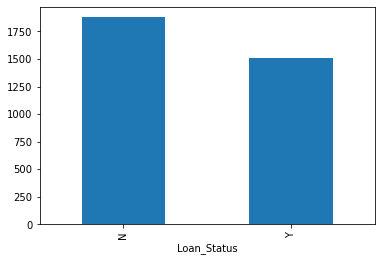

In [23]:
#Coapplicant Income
loan_train.groupby('Loan_Status').CoapplicantIncome.mean().plot.bar()

n this case, the results are even more surprising since we see that the mean of coaplicant income is higher for the rejected applications than for the approved ones.

0-500         279
500-1000       16
1000-1500      44
1500-2000      78
2000-2500      70
2500-3000      30
3000-3500      27
3500-4000      15
4000-4500      16
4500-5000       9
5000-6000      12
6000-7000       3
7000-42000     15
Name: CoapplicantIncome, dtype: int64

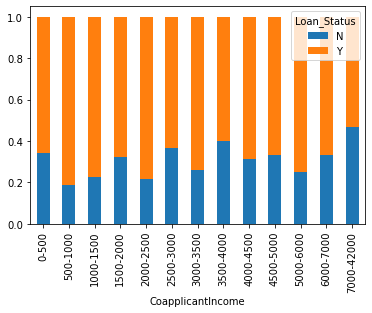

In [24]:
bins=[0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,7000,42000]
labels=[f'{i}-{j}' for i,j in zip(bins[:-1],bins[1:])]

loan_train.CoapplicantIncome_bin=pd.cut(loan_train.CoapplicantIncome,bins,labels=labels,include_lowest=True)
pd.crosstab(loan_train.CoapplicantIncome_bin,loan_train.Loan_Status,normalize='index').plot(kind='bar',stacked='True')
loan_train.CoapplicantIncome_bin.value_counts(sort=False)

In the representation with bin we cannot appreciate a trend indicating that higher coapplicant incomes increase the chances of approval. Actually, there is no clear pattern.

<AxesSubplot:xlabel='Loan_Status'>

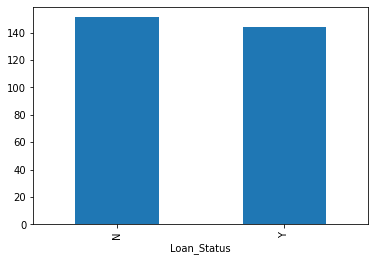

In [25]:
#LoanAmount
loan_train.groupby('Loan_Status').LoanAmount.mean().plot.bar()

0-25         4
25-50       19
50-75       46
75-100      85
100-125    134
125-150    104
150-175     70
175-250     78
250-700     52
Name: LoanAmount, dtype: int64

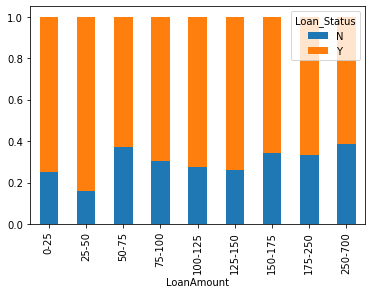

In [26]:
bins=[0,25,50,75,100,125,150,175,250,700]
labels=[f'{i}-{j}' for i,j in zip(bins[:-1],bins[1:])]

loan_train.LoanAmount_bin=pd.cut(loan_train.LoanAmount,bins,labels=labels,include_lowest=True)
pd.crosstab(loan_train.LoanAmount_bin,loan_train.Loan_Status,normalize='index').plot(kind='bar',stacked='True')
loan_train.LoanAmount_bin.value_counts(sort=False)


We can  appreciate that there are slighltly more rejections of the applications requesting higher loan amounts. In any case, the difference is small and does not allow to draw a solid conclussion.

As a general summary of the numerical variables, we can say that the independent analysis of each variable is not concluding. It only make sense to evaluate the response when combining the income variables with the loan amount . We will explore this later when we create a calculated variable (loan to income ratio)

#### 2.2.2 RELATION BETWEEN VARIABLES
We will now explore the relationship between the different variables in the dataset. For the numerical variables, we will use a pairplot and a heatmap. For the categorical, we will use a chi square test of independence.

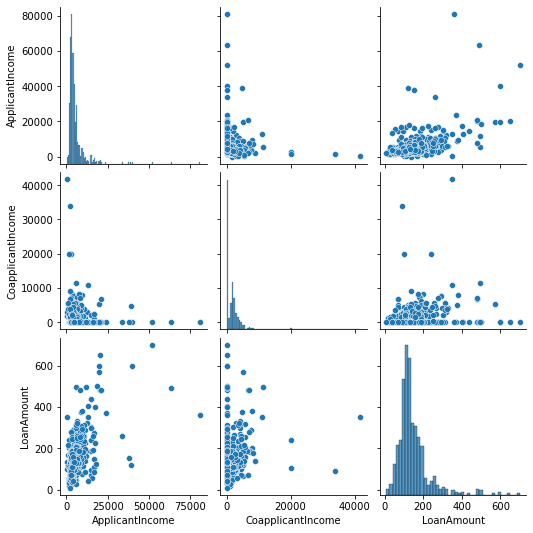

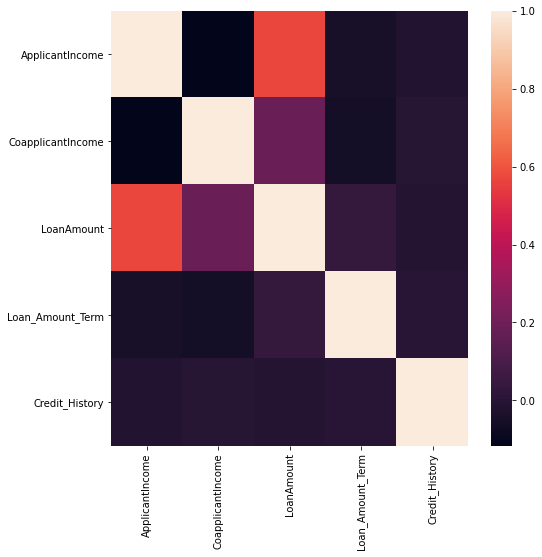

In [28]:
#Relation between numerical variables

sns.pairplot(loan_train,vars=num_columns,dropna=True)   
plt.figure(figsize=(8,8))
sns.heatmap(loan_train.corr())

plt.show()

We appreciate positive correlation between applicant income and loan amount. This was expected, since those applicants with higher income  will probably purchase more expensive properties. To a less extent, we see the same positive correlation between Coapplicant income and loan amount. Loan term and credit history do no present any significant correlation.

In [29]:
#Relation between categorical variables
chi_values={}
list_chi=[]
for i in range(len(cat_columns)):  
    for j in range(len(cat_columns)):  
        if j!=i:
            crosstable= pd.crosstab(loan_train[cat_columns[i]],loan_train[cat_columns[j]])
            chi,p,dof, ef= stats.chi2_contingency(crosstable)
            chi_values={'cat_1':cat_columns[i],'cat_2':cat_columns[j],'chi':chi,'p':p,'dof':dof,'ef':ef}
            list_chi.append(chi_values)
   
df_chi=pd.DataFrame(list_chi)
print(df_chi.loc[df_chi['p']<0.01,['cat_1','cat_2','p']])

         cat_1       cat_2       p
0       Gender     Married 0.00000
1       Gender  Dependents 0.00024
7      Married      Gender 0.00000
8      Married  Dependents 0.00000
14  Dependents      Gender 0.00024
15  Dependents     Married 0.00000


Taking as a reference a p value of 1% (p<0.01), we see that the stronger related variables are Gender-Married, Gender-Dependent and Married-Dependents